Generating the data using faker-
1. Metadata (e.g., login counts, product usage, number of support tickets, response times)

2. Support ticket text (complaints, urgency, sentiment)

In [3]:
pip install pandas faker numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 33.3 MB/s eta 0:00:00


monthly_logins: Poisson-distributed (skewed to integers near 20)

feature_usage_score: Normally distributed around 0.7, range clipped later to [0, 1]

num_tickets_last_30d: Poisson, average 5 tickets per month

avg_response_time: Skewed using exponential (some fast, some slow support response)

In [4]:
import pandas as pd
import numpy as np
import random
from faker import Faker

# Initialize faker and seed
fake = Faker()
random.seed(42)
np.random.seed(42)

# Re-generate metadata
account_ids = [f"ACC_{i:04d}" for i in range(1, 101)]
metadata = pd.DataFrame({
    "account_id": account_ids,
    "monthly_logins": np.random.poisson(lam=20, size=100),
    "feature_usage_score": np.round(np.random.normal(loc=0.7, scale=0.15, size=100), 2),
    "num_tickets_last_30d": np.random.poisson(lam=5, size=100),
    "avg_response_time": np.round(np.random.exponential(scale=2.0, size=100), 1),
})

# Clip values to keep in realistic ranges
metadata["feature_usage_score"] = metadata["feature_usage_score"].clip(0, 1)
metadata["avg_response_time"] = metadata["avg_response_time"].clip(0.1, 10)
#Ensures no unrealistic outliers (like a usage score of 1.5 or 0.01-second response times)

# Generate realistic ticket text and escalation flags with some noise
keywords = ["urgent", "immediately", "disappointed", "escalate", "unacceptable", "resolved", "NOW"]
ticket_logs = []

for account_id in account_ids:
    num_tickets = np.random.randint(1, 6)
    for _ in range(num_tickets):
        base_text = fake.sentence(nb_words=12)
        # Add keyword sometimes
        if random.random() < 0.25: #25% of the time, adds an escalation keyword (e.g., "unacceptable", "NOW")
            base_text += " " + random.choice(keywords)
        # Add variability to escalation logic
        escalated = 1 if ("urgent" in base_text or "escalate" in base_text) and random.random() > 0.2 else 0 #If urgent or escalate is present and 80% chance → label as escalated (1) (keeps it real)
        ticket_logs.append({
            "account_id": account_id,
            "ticket_text": base_text,
            "escalation_flag": escalated
        })

tickets_df = pd.DataFrame(ticket_logs)

# Save to CSV
metadata.to_csv("account_metadata.csv", index=False)
tickets_df.to_csv("support_ticket_logs.csv", index=False)

metadata.head(), tickets_df.head()

(  account_id  monthly_logins  feature_usage_score  num_tickets_last_30d  \
 0   ACC_0001              23                 0.75                     6   
 1   ACC_0002              15                 0.78                     7   
 2   ACC_0003              21                 0.86                     6   
 3   ACC_0004              25                 0.86                     7   
 4   ACC_0005              15                 0.49                     6   
 
    avg_response_time  
 0                0.6  
 1                1.8  
 2                0.1  
 3                1.4  
 4                1.8  ,
   account_id                                        ticket_text  \
 0   ACC_0001  Rise must top much system research century sel...   
 1   ACC_0002  Large color candidate term energy smile really...   
 2   ACC_0003  News physical cold hit available interest pres...   
 3   ACC_0004  Fund him truth open catch true money face can ...   
 4   ACC_0004  Name receive account generation where hims

| Line of Logic                  | Real-World Simulation                                         |
| ------------------------------ | ------------------------------------------------------------- |
| Poisson / Normal / Exponential | Simulates actual user behavior distributions                  |
| Keyword injection              | Creates **natural NLP signals** in a sparse and noisy way     |
| Randomized escalation logic    | Adds **label noise** → very realistic                         |
| Clipping scores                | Prevents extreme values breaking your model                   |
| Multiple tickets per account   | Allows **aggregation-based modeling**, e.g., % urgent tickets |


In [5]:
import os
os.listdir()

['.config', 'account_metadata.csv', 'support_ticket_logs.csv', 'sample_data']

In [6]:
from google.colab import files
files.download("account_metadata.csv")
files.download("support_ticket_logs.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
# Loading all other libraries
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from xgboost import XGBClassifier
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

In [10]:
# Download VADER lexicon
nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

Adding two features to extract the sentiment and whether it is urgent or not

In [11]:
# Feature engineering from text
vader = SentimentIntensityAnalyzer()

# Keywords that may indicate urgency or dissatisfaction - we defined them so we know them
escalation_keywords = ["urgent", "immediately", "disappointed", "escalate", "unacceptable", "NOW"]

In [12]:
def extract_features(text):
    text = text.lower()
    sentiment = vader.polarity_scores(text)["compound"]
    urgency_flag = int(any(word in text for word in escalation_keywords))
    return pd.Series([sentiment, urgency_flag])

tickets[["sentiment_score", "urgency_flag"]] = tickets["ticket_text"].apply(extract_features)

In [14]:
# Merging the datasets
agg_tickets = tickets.groupby("account_id").agg({
    "sentiment_score": "mean",
    "urgency_flag": "mean",
    "ticket_text": "count",
    "escalation_flag": "max"
}).rename(columns={"ticket_text": "ticket_count"})

Model deployment

In [15]:
df = pd.merge(metadata, agg_tickets, on="account_id")

In [16]:
features = ["monthly_logins", "feature_usage_score", "num_tickets_last_30d",
            "avg_response_time", "ticket_count", "sentiment_score", "urgency_flag"]
X = df[features]
y = df["escalation_flag"]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:36:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

Evalution

              precision    recall  f1-score   support

           0       0.76      0.87      0.81        15
           1       0.33      0.20      0.25         5

    accuracy                           0.70        20
   macro avg       0.55      0.53      0.53        20
weighted avg       0.66      0.70      0.67        20



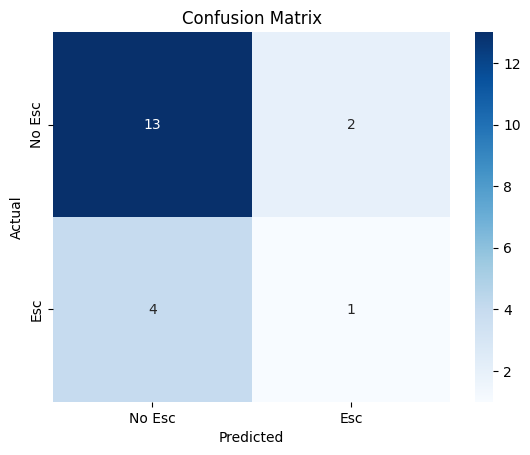

In [21]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Esc', 'Esc'], yticklabels=['No Esc', 'Esc'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

<ipython-input-22-6bbbe48572d8>:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X)


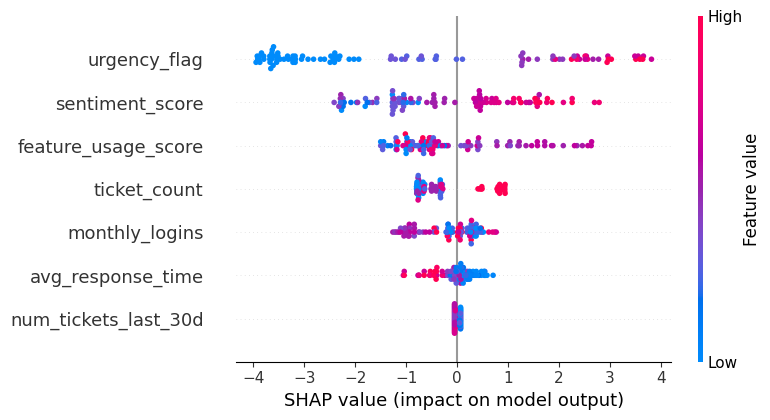

In [22]:
explainer = shap.Explainer(model)
shap_values = explainer(X)
shap.summary_plot(shap_values, X)

Since the false positives and negatives are high we need to improve accuracy:
1. Since the dataset has a class imbalance problem, we first tackle that
2. We will do more feature engineering

In [23]:
from imblearn.over_sampling import SMOTE

# Assume X contains features and y is the target (escalation_flag)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Apply SMOTE only on training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", pd.Series(y_train_resampled).value_counts())


Before SMOTE: escalation_flag
0    58
1    17
Name: count, dtype: int64
After SMOTE: escalation_flag
0    58
1    58
Name: count, dtype: int64


In [32]:
# Adding more NLP features
def add_nlp_features(df):
    # Capital ratio
    df['uppercase_ratio'] = df['ticket_text'].apply(lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0)

    # Punctuation
    df['exclamation_count'] = df['ticket_text'].str.count("!")
    df['question_count'] = df['ticket_text'].str.count("\?")

    # Text length
    df['text_length'] = df['ticket_text'].apply(len)

    # Keyword count
    keywords = ["urgent", "immediately", "disappointed", "escalate", "unacceptable", "NOW"]
    df['keyword_count'] = df['ticket_text'].apply(lambda x: sum(1 for kw in keywords if kw.lower() in x.lower()))

    return df

agg_tickets = add_nlp_features(tickets_df)


In [33]:
text_features_agg = agg_tickets.groupby('account_id').agg({
    'keyword_count': 'sum',
    'uppercase_ratio': 'mean',
    'exclamation_count': 'sum',
    'question_count': 'sum',
    'text_length': 'mean',
    'escalation_flag': 'max'  # This is your target
}).reset_index()

text_features_agg.rename(columns={'escalation_flag': 'target'}, inplace=True)

In [34]:
final_df = pd.merge(metadata, text_features_agg, on='account_id')
X = final_df.drop(columns=['account_id', 'target'])
y = final_df['target']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [36]:
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train_res, y_train_res)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87        19
           1       0.60      0.50      0.55         6

    accuracy                           0.80        25
   macro avg       0.72      0.70      0.71        25
weighted avg       0.79      0.80      0.79        25

[[17  2]
 [ 3  3]]


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:58:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


<ipython-input-37-f4e98fe8f4c9>:4: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test)


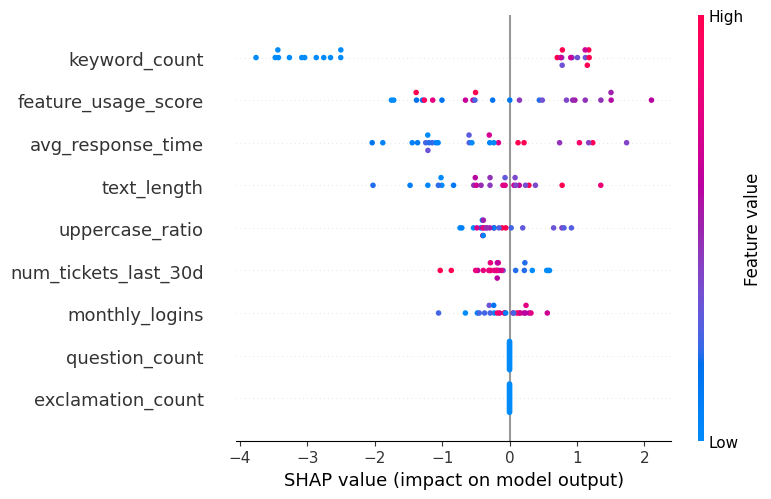

In [37]:
explainer = shap.Explainer(model, X_train_res)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)

Result:
Overall Accuracy: 80% — strong overall, but a bit misleading given class imbalance.

Recall for Escalations (Class 1): 50% — the model misses half of the actual escalation cases.

Precision for Escalations: 60% — 4 out of every 10 predicted escalations are false alarms.